## Тестирование стратегии на промежутке дней (год)
- запуск тестового алгоритма на любом временном промежутке
- возможность запуска разных комбинаций настроек и сравнения результатов

In [33]:
%reload_ext autoreload
%autoreload 2

In [34]:
import os
from dotenv import load_dotenv

load_dotenv()

TOKEN = os.getenv("INVEST_TOKEN")

TICKER = 'RNFT'
FIGI = 'BBG00F9XX7H4'

In [50]:
from lib.task_progress import TaskProgress
from test_env.test_alg import TestAlgorithm
from concurrent.futures import ThreadPoolExecutor, as_completed

# Определение максимального количества потоков
max_workers = 4  # N

# Создание списка всех параметров для тестов
# test_params = [
#     (max_shares, threshold_n, step_size, step_cnt, sleep_t)
#     for max_shares in [3, 4, 5, 6, 7]
#     for threshold_n in [3, 4, 5, 6, 7, 8]
#     for step_size in [.3, .4, .5, .6, .7, .8, 1]
#     for step_cnt in [2, 3, 4, 5, 6, 7]
#     for sleep_t in [1*60, 5*60, 10*60]
# ]
        
test_params = [
    (max_shares, threshold_n, step_size, step_cnt, sleep_t)
    for max_shares in [5]
    for threshold_n in [4]
    for step_size in [.5]
    for step_cnt in [3]
    for sleep_t in [1*60]
]
        
def run_test(max_shares, threshold_n, step_size, step_cnt, sleep_t):
    test_alg_ = TestAlgorithm(TOKEN, TICKER, FIGI)
    result = test_alg_.test(
        last_test_date='2024-03-15',
        test_days_num=251,  # 251,
        
        start_time='07:00',  # 10:00
        end_time='15:29',  # 18:29
        
        max_shares=max_shares,
        threshold_to_cancel_buy_steps=threshold_n,
        step_size=step_size,
        step_cnt=step_cnt,

        # quit_on_balance_up_percent=2,
        # quit_on_balance_down_percent=1,

        sleep_trading=sleep_t,
    )
    return result

results = []
progress = TaskProgress(len(test_params))

# Использование ThreadPoolExecutor для выполнения тестов в многопоточном режиме
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Запуск задач
    future_to_params = {executor.submit(run_test, *params): params for params in test_params}
    
    # Получение результатов выполнения задач по мере их завершения
    for future in as_completed(future_to_params):
        params = future_to_params[future]
        try:
            res = future.result()
            results.append(res)
            progress.update_progress()
        except Exception as exc:
            print(f'Generated an exception: {exc} for params: {params}')

# Вывод результатов или их дальнейшая обработка
sorted_results = sorted(results, key=lambda x: x['success_p'], reverse=True)

print()
for item in sorted_results:
    print(item)

# sorted_results

Запуск в 00:13
Закончено в 00:13, длительность 0:00:16                                                             

{'balance': 114.7, 'balance_change_avg': 0.46, 'days': 251, 'success_days': 178, 'success_p': 0.71, 'sleep_trading': 60, 'quit_on_balance_up_percent': 2, 'quit_on_balance_down_percent': 1, 'max_shares': 5, 'threshold_to_cancel_buy_steps': 4, 'step_size': 0.5, 'step_cnt': 3, 'operations_cnt': 3647, 'operations_avg': 14.53, 'op_not_closed': 0, 'op_not_closed_avg': 0.0}


In [ ]:
# archive = sorted_results
archive[:1]

## V6 Первый запуск

покупка в начале, продажа в конце, фикс учитывающий изменение баланса
'balance': 114.7, 'success_p': 0.71, 

добавлена первичная покупка и продажа в конце дня
'balance': -347.9, 'success_p': 0.68

тест разных вариантов настроек
по проценту - 'balance': -26235.8, 'success_p': 0.73
по сумме - 'balance': -2329.3, 'success_p': 0.23,

подрезание заявок снизу
'balance': -16860.0, 'success_p': 0.62

```
год -54607.4 руб  'success_p': 0.46
{'balance': -54607.4, 'balance_change_avg': -217.56, 'days': 251, 'success_days': 115, 'success_p': 0.46, 'profit_steps': 5, 'candles_count': 4, 'sleep_trading': 300, 'take_profit_percent': 1.5, 'quit_on_balance_up_percent': 2, 'quit_on_balance_down_percent': 1, 'operations_cnt': 4859, 'operations_avg': 19.36, 'op_not_closed': 0, 'op_not_closed_avg': 0.0}
```

```
день +1.8 руб
{'balance': 1.8, 'balance_change_avg': 1.8, 'days': 1, 'success_days': 1, 'success_p': 1.0, 'profit_steps': 5, 'candles_count': 4, 'sleep_trading': 60, 'take_profit_percent': 1.5, 'quit_on_balance_up_percent': 2, 'quit_on_balance_down_percent': 1, 'operations_cnt': 12, 'operations_avg': 12.0, 'op_not_closed': 0, 'op_not_closed_avg': 0.0}
```



## V5 последние показатели

```
[{'balance': -170.1,
  'balance_change_avg': -0.68,
  'days': 251,
  'success_days': 71,
  'success_p': 0.28,
  'profit_steps': 5,
  'candles_count': 4,
  'sleep_trading': 60,
  'take_profit_percent': 1.5,
  'quit_on_balance_up_percent': 2,
  'quit_on_balance_down_percent': 1,
  'operations_cnt': 2758,
  'operations_avg': 10.99,
  'op_not_closed': 171,
  'op_not_closed_avg': 0.68}]
```

## V4 результаты

```
[{'balance': -327.3,
  'balance_change_avg': -1.3,
  'days': 251,
  'success_days': 58,
  'success_p': 0.23,
  'profit_steps': 5,
  'candles_count': 4,
  'sleep_trading': 60,
  'operations_cnt': 5020,
  'operations_avg': 20.0,
  'op_not_closed': 134,
  'op_not_closed_avg': 0.53}]
```

> {'balance': -193.7, 'balance_change_avg': -0.77, 'days': 251, 'success_days': 65, 'success_p': 0.26, 'profit_steps': 5, 'candles_count': 4, 'sleep_trading': 300, 'operations_cnt': 1390, 'operations_avg': 5.54, 'op_not_closed': 148, 'op_not_closed_avg': 0.59}
-> -120

> {'balance': -138.9, 'balance_change_avg': -0.55, 'days': 251, 'success_days': 60, 'success_p': 0.24, 'profit_steps': 5, 'candles_count': 4, 'sleep_trading': 600, 'operations_cnt': 780, 'operations_avg': 3.11, 'op_not_closed': 112, 'op_not_closed_avg': 0.45}
-> -54

> {'balance': -327.3, 'balance_change_avg': -1.3, 'days': 251, 'success_days': 58, 'success_p': 0.23, 'profit_steps': 5, 'candles_count': 4, 'sleep_trading': 60, 'operations_cnt': 5020, 'operations_avg': 20.0, 'op_not_closed': 134, 'op_not_closed_avg': 0.53}
-> -170

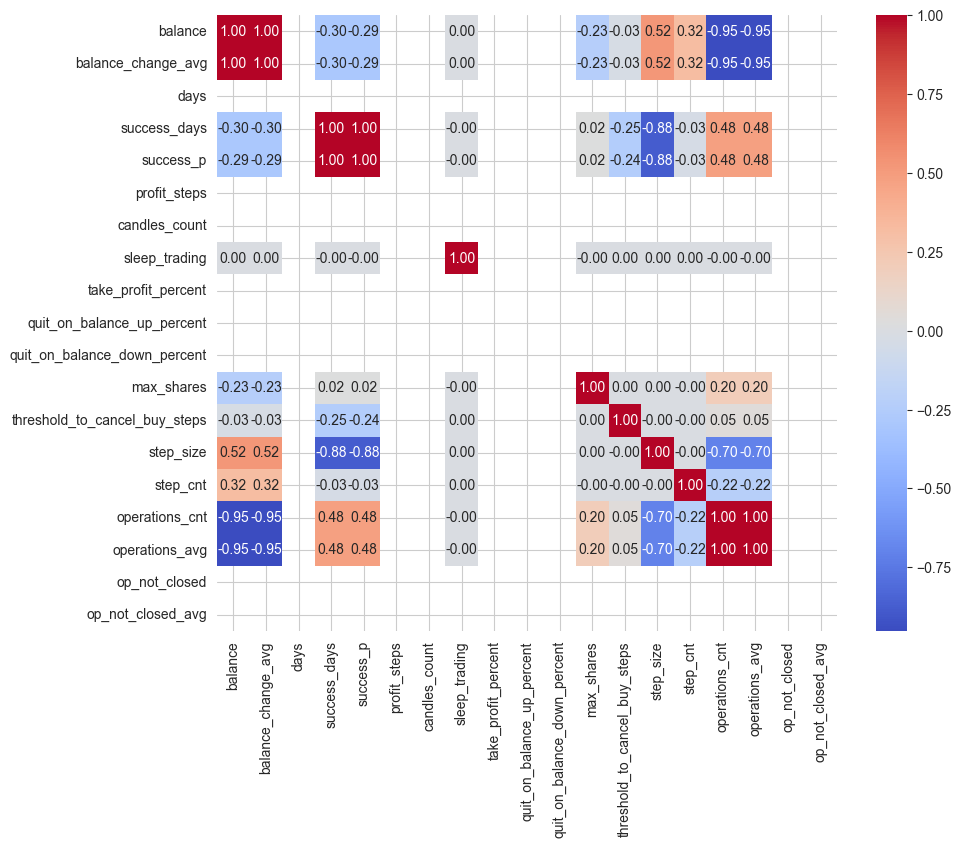

In [27]:
import pandas as pd

# Предположим, что data - это ваш список объектов
data = sorted_results

# Преобразование списка словарей в DataFrame
df = pd.DataFrame(data)

# Вычисление таблицы корреляции
correlation_matrix = df.corr()

# Вывод таблицы корреляции
# print(correlation_matrix)

# Для более наглядного отображения можно использовать seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()